In [1]:
import os
import cv2
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# eye_files = os.listdir('../data/168/gaze/') # eye-tracking file
box_files = os.listdir('./word_coordinates_backup1/') # all bounding boxes
img_files = os.listdir('./final_stimuli/') # screenshots of all the stimuli

# using regular expressions to get function name
img_names = []
for i, file in enumerate(box_files):
    img_name = re.sub('.png', '', img_files[i])
    img_names.append(img_name)


In [22]:
# This code was just run once to perform linear translations to 
# move boxes back into their original pixel coordinates
# for i in range(boxes.shape[0]):
#     x, y, w, h = boxes['x'][i], boxes['y'][i], boxes['width'][i], boxes['height'][i]
#     x += 10
#     y += 100

#     tangle = cv2.rectangle(img, (x, y), (x+w, y+h),(0, 255, 0, 2))  # drawing the rectangle

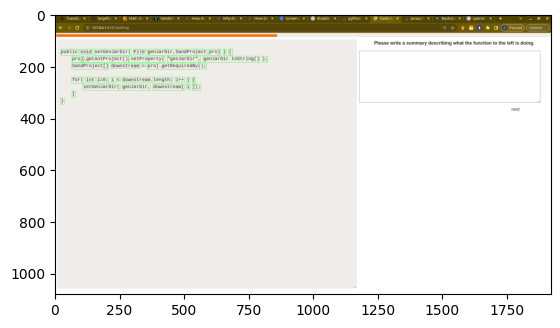

In [23]:
# plt.imshow(img)

In [255]:
height = 1080
width = 1920

def normalize_coordinates(x, y, w, h):
    x /= width
    y /= height
    w /= width
    h /= height
    return x, y, w, h


In [163]:
# This for loop normalizes the screen pixels to 0-1 coordinates, 
# which is how Tobii eyetracker output is formatted
for i, file in enumerate(box_files):
    
    box_name = re.sub('_boxes.csv', '', box_files[i]) #just the string
    imi = img_names.index(box_name) # index for image corresponding to word coordinates
    curr_img = img_files[imi] # getting the image file name
    img = cv2.imread(str('./final_stimuli/' + curr_img))
    
    curr_boxes = pd.read_csv(str('./word_coordinates/' + box_files[i])) # reading in word coordinates
    new_df = pd.DataFrame()
    for ii in range(curr_boxes.shape[0]): # adding pixels to align boxes
        x, y, w, h = curr_boxes['x'][ii], curr_boxes['y'][ii], curr_boxes['width'][ii], curr_boxes['height'][ii]
        nx, ny, nw, nh = normalize_coordinates(x, y, w, h) # normalizing here with function
        tobii_coords = pd.Series([nx, ny, nw, nh]).T
        new_row = pd.concat([curr_boxes.iloc[ii, :], tobii_coords])
        new_df = pd.concat([new_df, new_row], axis=1)
    new_df = new_df.T
    new_df = new_df.drop(['Unnamed: 0'], axis=1)
    new_df.to_csv(str('./word_coordinates_final_backup/' + box_files[i]), index=False, header=[
        'word', 'predicted_word', 'x', 'y', 'width', 'height', 'tobii_x', 
        'tobii_y', 'tobii_width', 'tobii_height'])
    
    

In [252]:
# This for loop is used to filter out parentheses from the bounding box files
# And keep track of the occurrences of words in the code (e.g. False.0, False.1, False.2)
count = 0
for i, file in enumerate(box_files):
    curr_boxes = pd.read_csv(str('./word_coordinates_final_backup/' + box_files[i])) # reading in word coordinates
    new_df = pd.DataFrame()
    
    ast_dict = {}
    curr_boxes.insert(loc=1, column="occurrence", value=0)
    for ii in range(curr_boxes.shape[0]): 
        word = curr_boxes['word'][ii]
        pointless = ['(', ')', '()', '{', '}', ');', '),', '));', 
                     '];', '[', ']', '))', '){', ';', ');', '});', '};', '((', ')){', 
                    ')[', '))));', ')))', ')(']
        if word in pointless: # ignoring whole boxes that are parentheses and brackets
            continue
        elif (isinstance(word, float)):
            temp = 'null'
        else:
            # pattern, replace with, string
            temp = re.sub(r'[(\){\}[\;\,]+$', '', word) # removing parentheses, etc. from the end of strings
            
        if temp not in ast_dict:
            ast_dict[temp] = 0
        else:
            ast_dict[temp] += 1

        new_row = curr_boxes.iloc[ii, :]
        new_row['word'] = temp
        new_row["occurrence"] = ast_dict[temp]
        new_df = pd.concat([new_df, new_row], axis=1)
        
    new_df = new_df.T
    new_df = new_df.drop('predicted_word', axis=1)
    new_df.to_csv(str('./word_coordinates_final/' + box_files[i]), index=False, header=[
        'word', 'occurrence', 'x', 'y', 'width', 'height', 'tobii_x', 
        'tobii_y', 'tobii_width', 'tobii_height'])


/var/folders/gs/vy6h2r3s2nz0dbr0dj9d56880000gn/T/ipykernel_4828/3425758759.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row['word'] = temp
/var/folders/gs/vy6h2r3s2nz0dbr0dj9d56880000gn/T/ipykernel_4828/3425758759.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["occurrence"] = ast_dict[temp]
/var/folders/gs/vy6h2r3s2nz0dbr0dj9d56880000gn/T/ipykernel_4828/3425758759.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [254]:
# Localize gaze to bounding boxes
